# Execute DAX queries in your Power BI environment via REST endpoint

Power BI allows the execution of DAX queries against a published Dataset via the _executeQueries_ endpoint:

[Datasets - Execute Queries](https://learn.microsoft.com/en-us/rest/api/power-bi/datasets/execute-queries)

If you don't have a Dataset available to use, you can create a sample dataset using one of the [built in samples](https://learn.microsoft.com/en-us/power-bi/create-reports/sample-datasets#install-built-in-samples). This document will use the "Retail Analysis Sample" example.

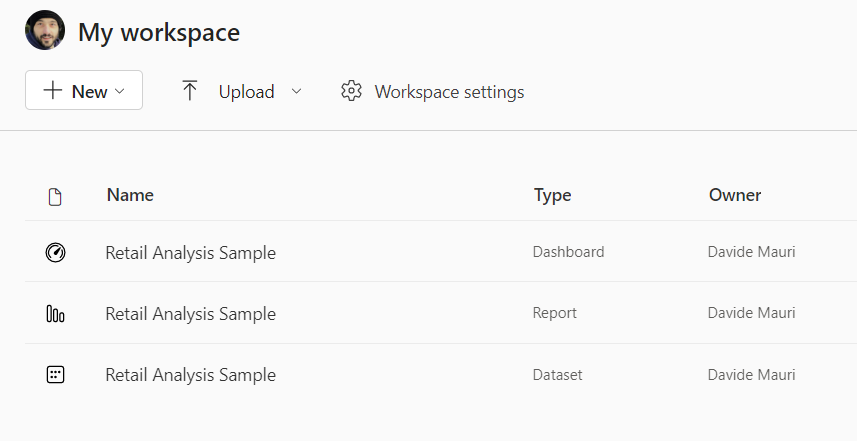

## Get the Dataset id

To discover the Dataset Id that is needed to execute a DAX query using the *executeQuery* endpoint, you can go to your Power BI portal, and click on the Dataset link:

The Dataset page will open up and the URL will be something like:

```
https://xyz.powerbi.com/groups/me/datasets/<DATASET_ID>/details
```

## Setup up the Database Scoped Credentials

Power BI REST endpoint requires authentication. You can get a token that represent your user by using AZ CLI:

```bash
az account get-access-token --resource "https://analysis.windows.net/powerbi/api" --query "accessToken" -o tsv
```

the command will output something similar to the following string:

```text
eyJ0eXAiOiJK.....5aOYpZSFrSiKYYD6Q
```

copy the whole string and use in the the following code replacing the \<TOKEN\> string after the `Bearer` text. Make sure also to replace the _<DATASET_ID>_ placeholder with the Dataset id you got in the previous step. Execute the T-SQL code. It will safely store the authentication token in a Database Scoped Credential so that it will be possible to use the token later with `sp_invoke_external_rest_endpoint`

In [ ]:
-- make sure a database master key exists
if not exists(select * from sys.symmetric_keys where [name] = '##MS_DatabaseMasterKey##') begin
    create master key encryption by password = 'LONg_Pa$$_w0rd!'
end

-- create database scoped credential
if exists(select * from sys.database_scoped_credentials where [name] = 'https://api.powerbi.com/v1.0/myorg/datasets/<DATASET_ID>/executeQueries') begin
    drop database scoped credential [https://api.powerbi.com/v1.0/myorg/datasets/<DATASET_ID>/executeQueries];
end
create database scoped credential [https://api.powerbi.com/v1.0/myorg/datasets/<DATASET_ID>/executeQueries]
with identity = 'HTTPEndpointHeaders', secret = '{"Authorization": "Bearer <TOKEN>"}';
go

## Execute DAX Query

Now you can call the *executeQueries* endpoint, passing the DAX query that you want to execute. Use the `string_escape` function to make sure everything will be correctly escaped when passed in the JSON payload.

When querying the returned result, remember that Power BI make extensive use of square brackes, which needs to be escaped in Azure SQL database, as used to delimit object names. You can use the double quotes to wrap the column name so that it will be considered valid and the square brackets will be treated as regulat characters (for example: `"District[District]"`), or you can escape the square brackets by adding one bracket at the start and *two* at the end (for example: `[District[District]]]`)

In [ ]:

declare @url nvarchar(4000) = N'https://api.powerbi.com/v1.0/myorg/datasets/<DATASET_ID>/executeQueries';
declare @payload nvarchar(max) = N'{
  "queries": [
    {
      "query": "' + string_escape('
        DEFINE VAR __DS0Core = 
        SUMMARIZECOLUMNS(
            ROLLUPADDISSUBTOTAL(''District''[District], "IsGrandTotalRowTotal"),
            "This_Year_Sales", ''Sales''[This Year Sales]
        )

        EVALUATE
        __DS0Core

        ORDER BY
        [IsGrandTotalRowTotal] DESC, ''District''[District]
        ', 'json') + '"
    }
  ],
  "serializerSettings": {
    "includeNulls": true
  }
}'

declare @ret int, @response nvarchar(max);

exec @ret = sys.sp_invoke_external_rest_endpoint 
	@method = 'POST',
	@url = @url,
	@payload = @payload,
	@credential = [https://api.powerbi.com/v1.0/myorg/datasets/<DATASET_ID>/executeQueries],
	@response = @response output;

select * from openjson(@response,  '$.result.results[0].tables[0].rows') with
  (
    "District[District]" nvarchar(100),
    "[IsGrandTotalRowTotal]" bit,
    "[This_Year_Sales]" numeric(18,9)
  )

The result will be something like:

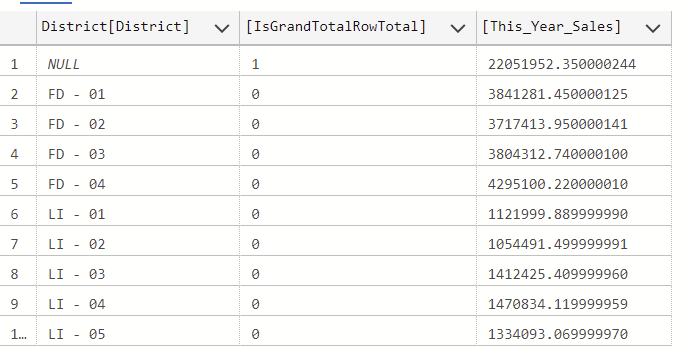